In [16]:
import math
import pandas as pd
import numpy as np
from scipy import stats
from matplotlib.pylab import plt
import seaborn as sns

In [17]:
movies_df = pd.read_csv("movies_with_franchises.csv", index_col = 0)
games_df = pd.read_csv("clean_games_with_franchises.csv", index_col = 0)

C:\Users\35387\AppData\Local\Temp\ipykernel_109712\1545051576.py:1: DtypeWarning: Columns (2,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_df = pd.read_csv("movies_with_franchises.csv", index_col = 0)


Naming convention to standardise the column names

In [18]:
games_df = games_df.rename(columns = {"titleType": "type", "rating": "age_rating", "startYear": "year", "primaryTitle": "title", "averageRating": "rating", "numVotes": "votes", "isAdult" : "is_adult"})
movies_df = movies_df.rename(columns={"startYear": "year", "primaryTitle": "title", "isAdult" : "is_adult", "runtimeMinutes": "runtime", "averageRating": "rating", "numVotes": "votes"})
movies_df = movies_df[["franchise_name", "franchise_id", "tconst", "title", "year", "is_adult", "runtime", "genres", "rating", "votes"]]

In [19]:
games_df.genres = games_df.genres.apply(lambda x: x.strip("[]").split(","))
games_df.genres = games_df.genres.apply(lambda x: [i.strip(" '") for i in x])
games_df.genres = games_df.genres.apply(lambda x: ', '.join(x))

In [20]:
movies_df["type"] = "movie"
games_df["type"] = "game"

In [21]:
complete_df = pd.concat([movies_df, games_df])

- Normalize movies and games 
- Calculate z-scores
- Add the following headings\
    &emsp;"Time until next movie"\
    &emsp;"Difference in rating"
    
    &emsp;"Number in Franchise"

Get number of movies/games in franchise

In [22]:
complete_df['franchise_count'] = complete_df['franchise_id'].map(complete_df['franchise_id'].value_counts())

Get total number of franchises:

In [23]:
complete_df[complete_df["type"] == "movie"].franchise_id.nunique()

1149

In [24]:
complete_df[complete_df["type"] == "games"].franchise_id.nunique()

0

Remove any movies or games where the total franchise count after matching the series is less than 3

In [25]:
complete_df[["franchise_id", "franchise_name", "franchise_count"]] = complete_df[["franchise_id", "franchise_name", "franchise_count"]].apply(lambda x: np.nan if x["franchise_count"] < 3 else x, axis=1)

Get total number of franchises with more than 3:

In [26]:
complete_df[complete_df["type"] == "movie"].franchise_id.nunique()

832

In [27]:
complete_df[complete_df["type"] == "game"].franchise_id.nunique()

1157

Remove non-numerical years from data and convert to int

In [28]:
def remove_null_years(year):
    if type(year) == str:
        if year == "\\N":
            return False
        else:
            return True
    else: 
        if math.isnan(year):
            return False
        else:
            return True

In [29]:
def fix_years(year):
    if type(year) == str:
        year = float(year)
        
    return year

In [30]:
complete_df["year_type"] = complete_df["year"].apply(lambda x : remove_null_years(x))
complete_df = complete_df[complete_df["year_type"]]
complete_df["year"] = complete_df["year"].apply(lambda x : int(x))
complete_df["year"].unique()

array([1939, 1940, 1941, 1942, 1943, 1944, 1967, 1968, 1970, 1974, 1976,
       1977, 1978, 1979, 2008, 1937, 1938, 2001, 2003, 2006, 2009, 2011,
       2013, 2015, 2017, 2019, 2021, 2005, 2018, 1981, 1982, 1988, 1989,
       1995, 1998, 2002, 2022, 1948, 1949, 1950, 1951, 1952, 1947, 1999,
       2004, 2012, 2014, 1980, 1984, 1983, 2016, 2007, 2010, 1996, 1997,
       1953, 1954, 1955, 1966, 1994, 2000, 1969, 1971, 1934, 1946, 1985,
       1987, 1990, 1991, 1993, 1992, 1986, 1961, 1964, 1958, 1972, 1973,
       1975, 1945, 1963, 1962, 2020, 2023, 1965, 1929, 1930, 1933, 1935,
       1936, 1922, 1923, 1924, 1926, 1927, 1928, 1931, 1916, 1959, 1960,
       1957, 1918, 1920, 1956, 1913, 1914, 1932, 1919, 1925, 1921, 1915,
       1917, 1894, 1897, 1905, 1906, 1907, 1908, 1909, 1910, 1912, 1911,
       1903, 1904, 1899, 1901, 1900, 1902, 1896], dtype=int64)

## Splitting the data
At this stage we are going to create 2 separate dataframes. The first will group all the franchises by year, and each year for each franchise will be a single entry. The second will keep all the individual entries for each year for each franchise. 

### Single Year Per Franchise

Create a copy

In [31]:
merged_years_df = complete_df.copy(deep=True)

Convert genres to list

In [32]:
merged_years_df["genres"] = merged_years_df.genres.apply(lambda x : x.split(','))

Get total for each year, for each franchise

In [33]:
merged_years_df['content_per_year'] = merged_years_df.groupby(["franchise_id", "year"])["year"].transform('count')

Create average votes and ratings for each franchise

In [34]:
grouped_movies = merged_years_df.groupby(["franchise_id", "year"]).agg({"votes": "mean", "rating": "mean"}).reset_index()
merged_years_df = pd.merge(merged_years_df, grouped_movies, on=["franchise_id", "year"], how="left", suffixes=(None, '_average'))

In [35]:
# group by name and release year, aggregate the franchise_id lists
merged_years_df = merged_years_df.groupby(['franchise_id', 'year'], as_index=False).agg(({
    'franchise_name': 'first',
    'franchise_id': 'first',
    "type": "first",
    'tconst': ", ".join,
    'title': ", ".join,
    "year": 'first',
    "is_adult": "first",
    "runtime" : "first",
    "genres": lambda x: list(set([i for l in x for i in l])),
    "votes_average": "first", 
    "rating_average": "first", 
    "franchise_count" : "first",
    "content_per_year": "first", 
    }))

Create columns that have the difference in year between the previous entries in the franchise, the difference in average vote count and avaerage rating

In [36]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year
2492,Ghosts 'n Goblins,3025-243,game,tt0366759,Maximo vs. Army of Zin,2003,0,None,"[Adventure, Action, Action-Adventure, Fantasy]",64.0,8.1,10.0,1.0


In [37]:
merged_years_df = merged_years_df.sort_values(["franchise_id", "year"])
merged_years_df['year_diff'] = merged_years_df.groupby(['franchise_id'])['year'].diff()
merged_years_df['vote_diff'] = merged_years_df.groupby(['franchise_id'])['votes_average'].diff()
merged_years_df['rating_diff'] = merged_years_df.groupby(['franchise_id'])['rating_average'].diff()
merged_years_df['num_of_releases_diff'] = merged_years_df.groupby(['franchise_id'])['content_per_year'].diff()

In [38]:
merged_years_df

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff
0,Mario,3025-1,game,tt0315808,Baseball,1978,0,None,"[ Family, Sports, Sport, Baseball]",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN
1,Mario,3025-1,game,tt0176664,Donkey Kong,1981,0,None,"[ Platformer, Action]",2011.0,7.40,195.0,1.0,3.0,1998.0,4.40,0.0
2,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,None,"[ Platformer, Action, Family]",170.5,6.50,195.0,2.0,1.0,-1840.5,-0.90,1.0
3,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,None,"[ Pinball, Fantasy, Sports, Baseball, \\N, ...",326.8,6.00,195.0,5.0,1.0,156.3,-0.50,3.0
4,Mario,3025-1,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,None,"[Golf, Sports, Sport, Puzzle, Action, Plat...",49.5,5.85,195.0,4.0,1.0,-277.3,-0.15,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10982,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0040018,it's forever springtime,1950,0,92,"[Drama, Comedy]",99.0,6.40,3.0,1.0,2.0,-212.0,-0.50,0.0
10983,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0044572,two cents worth of hope,1952,0,110,"[Romance, Comedy]",658.0,7.00,3.0,1.0,2.0,559.0,0.60,0.0
10984,It's Alive,f995,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"[Horror, Sci-Fi, Romance]",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN
10985,It's Alive,f995,movie,tt0077756,it lives again,1978,0,91,"[Horror, Sci-Fi]",2494.0,5.20,4.0,1.0,4.0,-2955.5,0.95,-1.0


At this stage, the merged_year_df contains all the movies within a franchise, grouped by year of release for each franchise, with columns that show how the number of releases, rating and vote count changed from the previous release year, and the number of years between subsequent releases. We'll export this information as a csv

In [39]:
merged_years_df["year_diff"].describe()

count    8998.000000
mean        2.995555
std         3.891119
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        47.000000
Name: year_diff, dtype: float64

### Returning to our original dataframe

Create additional columns for the datasets containing average rating for the franchises

In [40]:
complete_df

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count,year_type
0,The Aldrich Family,f0,tt0032123,what a life,1939,0,75,"Comedy,Drama",6.9,93.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,11.0,True
1,The Aldrich Family,f0,tt0033834,life with henry,1940,0,80,"Comedy,Family,Music",6.0,49.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,11.0,True
2,The Aldrich Family,f0,tt0033708,henry aldrich for president,1941,0,75,"Comedy,Family",6.6,146.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,11.0,True
3,The Aldrich Family,f0,tt0034842,"henry aldrich, editor",1942,0,72,"Comedy,Drama,Family",6.4,150.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,11.0,True
4,The Aldrich Family,f0,tt0034844,henry and dizzy,1942,0,71,"Comedy,Family",7.2,58.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,11.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16985,NaN,NaN,tt9888864,Infernal,2007,0,NaN,Action,6.0,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN,True
16986,NaN,NaN,tt9892552,Spiral Splatter,2017,0,NaN,Action,2.0,10.0,game,NaN,85.5,NaN,NaN,NaN,NaN,NaN,True
16987,NaN,NaN,tt9893348,Alien: Covenant In Utero VR Experience,2017,0,NaN,Sci-Fi,6.2,17.0,game,NaN,90.0,NaN,NaN,NaN,NaN,NaN,True
16988,LEGO,3025-448,tt9893804,The Lego Movie 2 Videogame,2019,0,NaN,"Animation, Adventure, Family, Action-Adventure",5.5,156.0,game,22035.0,100.0,['TT Games'],"['PC', 'Xbox One', 'PlayStation 4', 'Nintendo ...",['WB Games'],NaN,56.0,True


## *Note*
Using value_counts we discover 25% of our movies for the franchises are released in the same year. So we have to either get an average per year (in this case, we are looking at fatique over years as opposed to number of movies)

In [41]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff
3831,Indiana Jones,3025-358,game,tt5586124,Indiana Jones and His Desktop Adventures,1996,0,None,"[Adventure, Action]",12.0,7.0,17.0,1.0,2.0,-40.0,0.55,-1.0


# Normalize and z-scores

In [42]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'rating_average'])
merged_years_df.loc[merged_years_df["type"] == "game", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'rating_average'])


In [43]:
cols = ["tconst", "rating_average", "votes_average", "year"]

games_scores = merged_years_df[merged_years_df["type"] == "game"][cols]

movies_scores = merged_years_df[merged_years_df["type"] == "movie"][cols]

In [44]:
%matplotlib inline

sns.set_context("talk", font_scale=.9)   
sns.set_context('talk')

fig_width, fig_height = 4, 3

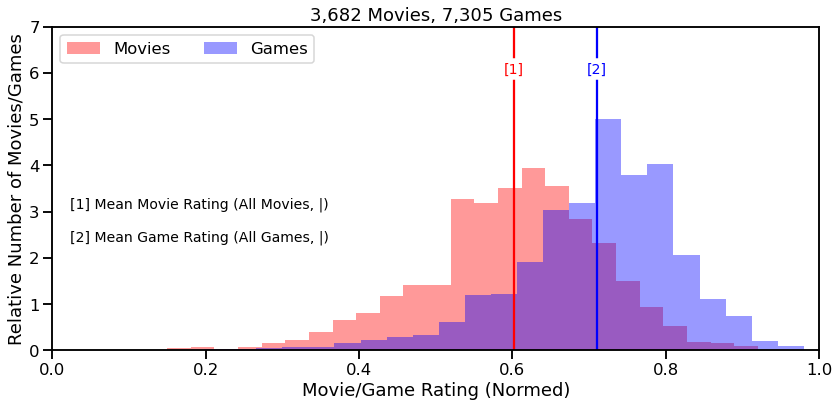

In [45]:
fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))

interval = 0.01
((movies_scores['rating_average']/10)).hist(
    bins=25, ax=ax, grid=False, color="red", density=True, alpha=.4)
((games_scores['rating_average']/10)).hist(
    bins=25, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_ylim(0, 7)
ax.set_xlim(0, 1)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

mean_movie_rating = (movies_scores['rating_average']/10).mean()
mean_game_rating = (games_scores['rating_average']/10).mean()

ax.axvline(mean_movie_rating, color="red")
ax.axvline(mean_game_rating, color="blue")

ax.text(mean_movie_rating, 6, '[1]', ha='center',color="red", backgroundcolor='w', fontsize=14)

ax.text(mean_game_rating, 6, '[2]', ha='center',color="blue", backgroundcolor='w', fontsize=14)


ax.text(
    0, 2,
    '''
    [1] Mean Movie Rating (All Movies, |)
    
    [2] Mean Game Rating (All Games, |)
    ''',
    fontsize=14
)

ax.set_xlabel('Movie/Game Rating (Normed)')
ax.set_ylabel('Relative Number of Movies/Games')

ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_scores), len(games_scores)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_1_normed_rating_distributions.png', format='png', dpi=300)

In [46]:
merged_years_df[merged_years_df["type"] == "movie"]['rating_average'].agg(['mean', 'std'])

mean    6.019407
std     1.143356
Name: rating_average, dtype: float64

In [47]:
(merged_years_df[merged_years_df["type"] == "movie"]['rating_average']-merged_years_df[merged_years_df["type"] == "movie"]['rating_average'].mean())/complete_df[complete_df["type"] == "movie"]['rating'].std()

7305     0.646067
7306    -0.014239
7307     0.425965
7308     0.572700
7309     0.719435
           ...   
10982    0.279231
10983    0.719435
10984   -1.298167
10985   -0.601177
10986   -0.894647
Name: rating_average, Length: 3682, dtype: float64

In [48]:
stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])

7305     0.770287
7306    -0.016976
7307     0.507866
7308     0.682813
7309     0.857760
           ...   
10982    0.332918
10983    0.857760
10984   -1.547765
10985   -0.716766
10986   -1.066660
Name: rating_average, Length: 3682, dtype: float64

In [49]:
stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average']).mean()

6.061299087728109e-16

In [50]:
merged_years_df["z_rating"] = np.nan

In [51]:
merged_years_df[merged_years_df["type"] == "movie"]['z_rating'] = stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])
merged_years_df.sort_values("z_rating")

C:\Users\35387\AppData\Local\Temp\ipykernel_109712\1374468612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_years_df[merged_years_df["type"] == "movie"]['z_rating'] = stats.zscore(merged_years_df[merged_years_df["type"] == "movie"]['rating_average'])


,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating
0,Mario,3025-1,game,tt0315808,Baseball,1978,0,None,"[ Family, Sports, Sport, Baseball]",13.0,3.00,195.0,1.0,NaN,NaN,NaN,NaN,NaN
1,Mario,3025-1,game,tt0176664,Donkey Kong,1981,0,None,"[ Platformer, Action]",2011.0,7.40,195.0,1.0,3.0,1998.0,4.40,0.0,NaN
2,Mario,3025-1,game,"tt0204287, tt3472820","Donkey Kong Junior, Donkey Kong",1982,0,None,"[ Platformer, Action, Family]",170.5,6.50,195.0,2.0,1.0,-1840.5,-0.90,1.0,NaN
3,Mario,3025-1,game,"tt0176971, tt0185909, tt0302501, tt2318635, tt...","Mario Bros., Baseball, Donkey Kong, Pinball, M...",1983,0,None,"[ Pinball, Fantasy, Sports, Baseball, \\N, ...",326.8,6.00,195.0,5.0,1.0,156.3,-0.50,3.0,NaN
4,Mario,3025-1,game,"tt0185017, tt0186168, tt3404206, tt3410580","Wrecking Crew, Golf, Mario Bros. Special, Punc...",1984,0,None,"[Golf, Sports, Sport, Puzzle, Action, Plat...",49.5,5.85,195.0,4.0,1.0,-277.3,-0.15,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10982,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0040018,it's forever springtime,1950,0,92,"[Drama, Comedy]",99.0,6.40,3.0,1.0,2.0,-212.0,-0.50,0.0,NaN
10983,Renato Castellani's Italian neorealism trilogy,f994,movie,tt0044572,two cents worth of hope,1952,0,110,"[Romance, Comedy]",658.0,7.00,3.0,1.0,2.0,559.0,0.60,0.0,NaN
10984,It's Alive,f995,movie,"tt0071198, tt0071675","the bat people, it's alive",1974,0,93,"[Horror, Sci-Fi, Romance]",5449.5,4.25,4.0,2.0,NaN,NaN,NaN,NaN,NaN
10985,It's Alive,f995,movie,tt0077756,it lives again,1978,0,91,"[Horror, Sci-Fi]",2494.0,5.20,4.0,1.0,4.0,-2955.5,0.95,-1.0,NaN


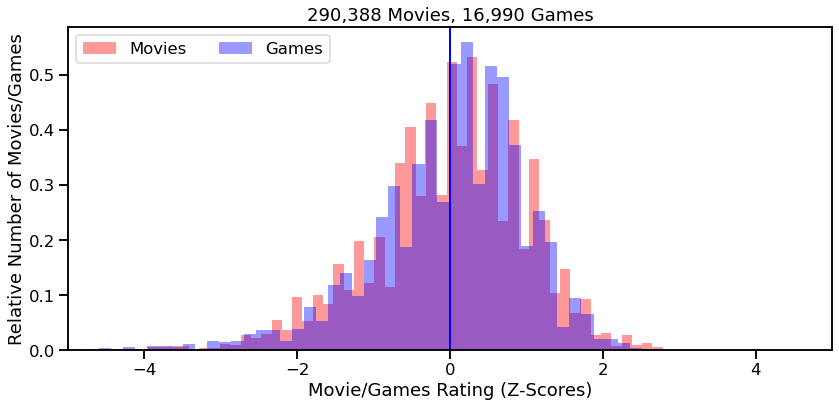

In [52]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'rating_average'])

merged_years_df.loc[merged_years_df["type"] == "game", 'z_rating'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'rating_average'])

fig, ax = plt.subplots(figsize=(fig_width*3, fig_height*2))


((merged_years_df[merged_years_df["type"] == "movie"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="red", density=True, alpha=.4)
((merged_years_df[merged_years_df["type"] == "game"]['z_rating'])).hist(
    bins=50, ax=ax, grid=False, color="blue", density=True, alpha=.4)


ax.set_xlim(-5, 5)

ax.legend(['Movies', 'Games'], ncol=2, loc='upper left')

ax.axvline((merged_years_df[merged_years_df["type"] == "movie"]['z_rating']).mean(), lw=2, c="red")
ax.axvline((merged_years_df[merged_years_df["type"] == "game"]['z_rating']).mean(), lw=2, c="blue")


ax.set_xlabel('Movie/Games Rating (Z-Scores)')
ax.set_ylabel('Relative Number of Movies/Games')
ax.set_title('{:,} Movies, {:,} Games'.format(len(movies_df), len(games_df)))

fig.tight_layout()

#fig.savefig('../../graphs/2400_fig_2_z_rating_distributions.png', format='png', dpi=300)

In [53]:
merged_years_df.loc[merged_years_df["type"] == "movie", 'z_votes'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "movie", 'votes_average'])
merged_years_df.loc[merged_years_df["type"] == "game", 'z_votes'] = stats.zscore(merged_years_df.loc[merged_years_df["type"] == "game", 'votes_average'])

In [54]:
complete_df.sample()

,franchise_name,franchise_id,tconst,title,year,is_adult,runtime,genres,rating,votes,type,game_id,best_fit_ratio,developers,platforms,publishers,age_rating,franchise_count,year_type
226738,NaN,NaN,tt2808030,byl sobie dzieciak,2012,0,91,"Drama,War",4.0,34.0,movie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [55]:
merged_years_df.sample()

,franchise_name,franchise_id,type,tconst,title,year,is_adult,runtime,genres,votes_average,rating_average,franchise_count,content_per_year,year_diff,vote_diff,rating_diff,num_of_releases_diff,z_rating,z_votes
7787,Parker Family Saga,f122,movie,tt0085334,a christmas story,1983,0,93,"[Family, Comedy]",160546.0,7.9,3.0,1.0,NaN,NaN,NaN,NaN,1.645023,0.501248


In [56]:
test = merged_years_df[(merged_years_df["type"] == "movie") & (merged_years_df["votes_average"] > 100)]
test["votes_average"].describe()

count    3.196000e+03
mean     7.533188e+04
std      2.019385e+05
min      1.007500e+02
25%      6.220000e+02
50%      3.569000e+03
75%      3.523400e+04
max      2.700528e+06
Name: votes_average, dtype: float64

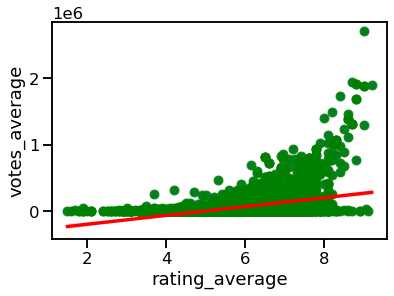

In [57]:
x = test["rating_average"]
y = test["votes_average"]

sns.scatterplot(x =x, y = y)
sns.regplot(x=x, y = y, scatter_kws = dict(color = "green"), line_kws = {"color": "red"})
#plt.yscale("log")
plt.show()

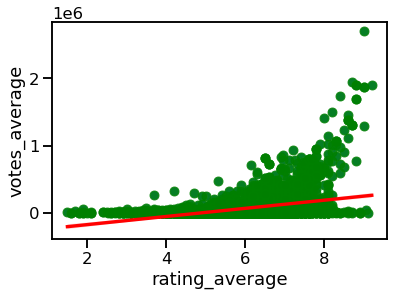

In [58]:
x = merged_years_df[merged_years_df["type"] == "movie"]["rating_average"]
y = merged_years_df[merged_years_df["type"] == "movie"]["votes_average"]

sns.scatterplot(x =x, y = y)
sns.regplot(x=x, y = y, scatter_kws = dict(color = "green"), line_kws = {"color": "red"})
plt.show()

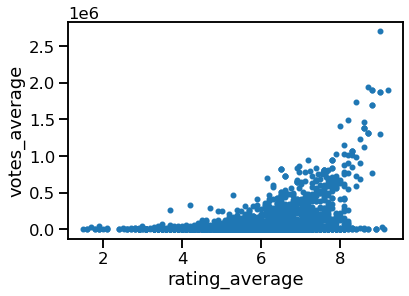

In [59]:
ax = merged_years_df[merged_years_df["type"] == "movie"].plot.scatter(x = "rating_average", y = "votes_average")
#ax.set_xlim(-6, 6)
#ax.set_ylim(-6, 6)

In [60]:
merged_years_df.to_csv("franchises_combined_by_year.csv")

## Additional Unused Code

In [ ]:
def sample_func(sub_df):
    
    movies_in_order = sub_df.sort_values('year')['tconst']
    return pd.Series({movie: k+1 for k, movie in enumerate(movies_in_order)})

In [ ]:
sample_df = movies_df.sample(10000)
grouped_df = sample_df.groupby('franchise_id').apply(sample_func)

In [ ]:
franchise_df = grouped_df[grouped_df['franchise_id'] == 'f1334']

In [ ]:
sample_func(franchise_df)

In [ ]:
l = ['a','b','c']
for k,i in enumerate(l):
    print(k,i)
    print(i,  '-->',  k+1)

In [ ]:
franchise_df.sort_values('startYear')['startYear']

In [ ]:
franchise_df.set_index('tconst').sort_values('startYear')['startYear'].map(int).diff()